In [1]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
from peft import PrefixTuningConfig, get_peft_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from peft import LoraConfig
import pandas as pd
import os
import csv
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

2025-04-22 18:32:24.388161: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-22 18:32:24.404217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745346744.420105   73699 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745346744.425076   73699 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-22 18:32:24.443407: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
def count_trainable_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [3]:
def prepare_mrpc_dataset(tokenizer):
    max_len = 512

    def encode(examples):
        return tokenizer(
            examples['sentence1'],
            examples['sentence2'],
            truncation=True,
            padding='max_length',
            max_length=max_len
        )

    raw_dataset = load_dataset("glue", "mrpc")
    encoded = raw_dataset.map(encode, batched=True)
    encoded = encoded.rename_column("label", "labels")
    encoded.set_format("torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])

    return encoded


In [4]:
def prepare_rte_dataset(tokenizer):
    max_len = 512

    def encode(examples):
        return tokenizer(
            examples['sentence1'],
            examples['sentence2'],
            truncation=True,
            padding='max_length',
            max_length=max_len
        )

    raw_dataset = load_dataset("glue", "rte")
    encoded = raw_dataset.map(encode, batched=True)
    encoded = encoded.rename_column("label", "labels")
    encoded.set_format("torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])
    # ✅ Inspect label distribution
    # encoded.set_format("torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"], output_all_columns=False)
    # encoded["train"] = encoded["train"].map(lambda x: {"labels": int(x["labels"])})
    # encoded["validation"] = encoded["validation"].map(lambda x: {"labels": int(x["labels"])})

    print("✅ Encoded RTE train label values:", torch.unique(encoded["train"]["labels"]))
    print("✅ Encoded RTE validation label values:", torch.unique(encoded["validation"]["labels"]))

    return encoded


In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
_ = prepare_rte_dataset(tokenizer)


✅ Encoded RTE train label values: tensor([0, 1])
✅ Encoded RTE validation label values: tensor([0, 1])


In [6]:
def prepare_sst2_dataset(tokenizer):
    max_len = 512  # no prefix subtraction

    def encode(examples):
        return tokenizer(
            examples['sentence'],
            truncation=True,
            padding='max_length',
            max_length=max_len
        )

    raw_dataset = load_dataset("glue", "sst2")
    encoded = raw_dataset.map(encode, batched=True)
    encoded = encoded.rename_column("label", "labels")
    encoded.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

    return encoded


In [7]:
from datasets import DatasetDict
def prepare_imdb_dataset(tokenizer):
    max_len = 512 

    raw_dataset = load_dataset("imdb")
    split = raw_dataset["train"].train_test_split(test_size=0.1, seed=42)
    data = DatasetDict({
        "train": split["train"],
        "validation": split["test"],
    })

    def encode(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=max_len,
        )

    encoded = data.map(encode, batched=True)
    encoded = encoded.rename_column("label", "labels")
    encoded.set_format("torch", columns=[
        "input_ids", "token_type_ids", "attention_mask", "labels"
    ])
    return encoded

In [8]:
def prepare_mrpc_dataset(tokenizer):
    max_len = 512

    def encode(examples):
        return tokenizer(
            examples['sentence1'],
            examples['sentence2'],
            truncation=True,
            padding='max_length',
            max_length=max_len
        )

    raw_dataset = load_dataset("glue", "mrpc")
    encoded = raw_dataset.map(encode, batched=True)
    encoded = encoded.rename_column("label", "labels")
    encoded.set_format("torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])

    return encoded

In [12]:
def prepare_tweet_dataset_emotion(tokenizer):
    max_len = 512

    def encode(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=max_len,
        )

    raw_dataset = load_dataset("tweet_eval", "emotion")
    encoded = raw_dataset.map(encode, batched=True)
    encoded = encoded.rename_column("label", "labels")
   # encoded.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    encoded.set_format("torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])


    print("✅ Encoded TweetEval train label values:", torch.unique(encoded["train"]["labels"]))
    print("✅ Encoded TweetEval validation label values:", torch.unique(encoded["validation"]["labels"]))
    
    return encoded


In [ ]:
def prepare_tweet_dataset(tokenizer):
    max_len = 512

    def encode(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=max_len,
        )

    raw_dataset = load_dataset("tweet_eval", "sentiment")
    encoded = raw_dataset.map(encode, batched=True)
    encoded = encoded.rename_column("label", "labels")
   # encoded.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    encoded.set_format("torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])


    print("✅ Encoded TweetEval train label values:", torch.unique(encoded["train"]["labels"]))
    print("✅ Encoded TweetEval validation label values:", torch.unique(encoded["validation"]["labels"]))
    
    return encoded


In [15]:
from collections import Counter

def run_lora_experiment(dataset_name, lora_rank=8, results_file="lora_results.csv", prefix_tokens=0):
    assert dataset_name in {"sst2", "mrpc", "rte", "imdb", "tweet","tweet_emotion"}

    # === Load Tokenizer & Dataset ===
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    if dataset_name == "sst2":
        encoded = prepare_sst2_dataset(tokenizer)
        num_labels = 2
    elif dataset_name == "mrpc":
        encoded = prepare_mrpc_dataset(tokenizer)
        num_labels = 2
    elif dataset_name == "rte":
        encoded = prepare_rte_dataset(tokenizer)
        num_labels = 2
    elif dataset_name == "imdb":
        encoded = prepare_imdb_dataset(tokenizer)
        num_labels = 2
    elif dataset_name == "tweet":
        encoded = prepare_tweet_dataset(tokenizer)
        num_labels = 3
    elif(dataset_name == "tweet_emotion"):
        encoded = prepare_tweet_dataset_emotion(tokenizer)
        num_labels = 4

    # === Load Base Model ===
    base_model = AutoModelForSequenceClassification.from_pretrained(
        "bert-base-uncased", num_labels=num_labels
    )

    # === Apply LoRA ===
    lora_config = LoraConfig(
        task_type="SEQ_CLS",
        r=lora_rank,
        lora_alpha=2 * lora_rank,
        lora_dropout=0.1,
        bias="none",
    )
    model = get_peft_model(base_model, lora_config)

    # === Count Trainable Params ===
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"🔢 Trainable parameters (LoRA r={lora_rank}): {num_params:,}")

    # === Output Directory ===
    output_dir = f"./lora_r{lora_rank}_{dataset_name}_output"
    os.makedirs(output_dir, exist_ok=True)

    # === Training Args ===
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        learning_rate=1e-4,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        logging_steps=50,
        save_strategy="epoch",
        load_best_model_at_end=True,
        save_total_limit=1,
        report_to="none",
        fp16=True,
    )

    # === Eval Set Logic ===
    # if dataset_name == "mrpc" or  dataset_name == "tweet":
    #     eval_set = encoded.get("validation", encoded["test"])
    # else:
    #     eval_set = encoded["validation"]
    #     print(f"🧪 Using validation set for {dataset_name.upper()}")
    eval_set = encoded["validation"]

    eval_labels = [int(x["labels"]) for x in eval_set]
    print("✅ Unique eval labels:", set(eval_labels))

    print("Model expects num_labels =", model.config.num_labels)
    print("Label distribution:", Counter(encoded["train"]["labels"].tolist()))


    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=encoded["train"],
        eval_dataset=eval_set,
        compute_metrics=lambda p: {
            "accuracy": (p.predictions.argmax(-1) == p.label_ids).mean()
        },
    )

    # === Train + Evaluate ===
    trainer.train()
    metrics = trainer.evaluate()
    acc = round(metrics.get("eval_accuracy", 0.0), 4)
    print(f"✅ {dataset_name.upper()} | LoRA r={lora_rank} | Accuracy: {acc:.4f}")

    # === Save Best Model Weights ===
    best_model_path = os.path.join(output_dir, "best_model.pt")
    torch.save(model.state_dict(), best_model_path)
    print(f"💾 Saved best model to: {best_model_path}")

    # === Log to CSV ===
    if results_file:
        write_header = not os.path.exists(results_file)
        with open(results_file, "a", newline="") as f:
            writer = csv.writer(f)
            if write_header:
                writer.writerow(["dataset", "lora_rank", "trainable_params", "accuracy"])
            writer.writerow([dataset_name, lora_rank, num_params, acc])

    return {
        "dataset": dataset_name,
        "lora_rank": lora_rank,
        "trainable_params": num_params,
        "accuracy": acc,
        "model_path": best_model_path
    }


In [14]:
results = []
for r in [1, 5, 10, 30]:
    res = run_lora_experiment("mrpc", lora_rank=r)
    results.append(res)

# You can now print them or save as DataFrame
print(pd.DataFrame(results))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔢 Trainable parameters (LoRA r=1): 38,402


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.640100,0.637070,0.664928
2,0.623200,0.620786,0.664928
3,0.599700,0.602329,0.677681


✅ MRPC | LoRA r=1 | Accuracy: 0.6777
💾 Saved best model to: ./lora_r1_mrpc_output/best_model.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


🔢 Trainable parameters (LoRA r=5): 185,858


Epoch,Training Loss,Validation Loss,Accuracy
1,0.614900,0.588244,0.691014
2,0.572900,0.543111,0.728696
3,0.530500,0.540185,0.729275


✅ MRPC | LoRA r=5 | Accuracy: 0.7293
💾 Saved best model to: ./lora_r5_mrpc_output/best_model.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


🔢 Trainable parameters (LoRA r=10): 370,178


Epoch,Training Loss,Validation Loss,Accuracy
1,0.594100,0.564340,0.710725
2,0.558500,0.522085,0.752464
3,0.507900,0.518030,0.764638


✅ MRPC | LoRA r=10 | Accuracy: 0.7646
💾 Saved best model to: ./lora_r10_mrpc_output/best_model.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


🔢 Trainable parameters (LoRA r=30): 1,107,458


Epoch,Training Loss,Validation Loss,Accuracy
1,0.561300,0.528481,0.746087
2,0.503200,0.429368,0.803478
3,0.407700,0.407986,0.821449


✅ MRPC | LoRA r=30 | Accuracy: 0.8214
💾 Saved best model to: ./lora_r30_mrpc_output/best_model.pt
  dataset  lora_rank  trainable_params  accuracy  \
0    mrpc          1             38402    0.6777   
1    mrpc          5            185858    0.7293   
2    mrpc         10            370178    0.7646   
3    mrpc         30           1107458    0.8214   

                             model_path  
0   ./lora_r1_mrpc_output/best_model.pt  
1   ./lora_r5_mrpc_output/best_model.pt  
2  ./lora_r10_mrpc_output/best_model.pt  
3  ./lora_r30_mrpc_output/best_model.pt  


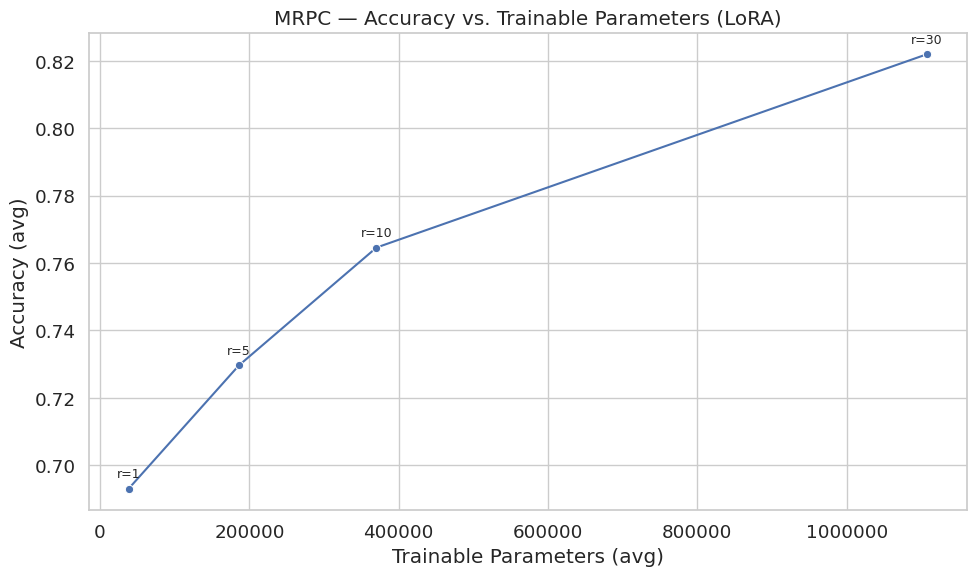

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Load CSV
df = pd.read_csv("lora_results.csv")

# Extract dataset name (assumes all from same dataset)
dataset_name = df["dataset"].iloc[0].upper()

# Group by LoRA rank and average accuracy + params
grouped = df.groupby("lora_rank").agg({
    "accuracy": "mean",
    "trainable_params": "mean"
}).reset_index().sort_values("trainable_params")

# Seaborn styling
sns.set(style="whitegrid", font_scale=1.2)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=grouped, x="trainable_params", y="accuracy", marker="o")

# Format x-axis as full integers
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style="plain", axis="x")

# Annotate each point with r
for _, row in grouped.iterrows():
    plt.annotate(f"r={int(row['lora_rank'])}", (row["trainable_params"], row["accuracy"]),
                 textcoords="offset points", xytext=(0, 8), ha='center', fontsize=9)

plt.xlabel("Trainable Parameters (avg)")
plt.ylabel("Accuracy (avg)")
plt.title(f"{dataset_name} — Accuracy vs. Trainable Parameters (LoRA)")
plt.tight_layout()
plt.show()


In [9]:
results2 = []
for r in [1, 5, 10, 30]:
    res = run_lora_experiment("rte", lora_rank=r)
    results2.append(res)

# You can now print them or save as DataFrame
print(pd.DataFrame(results2))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Encoded RTE train label values: tensor([0, 1])
✅ Encoded RTE validation label values: tensor([0, 1])
🔢 Trainable parameters (LoRA r=1): 38,402
🧪 Using validation set for RTE (test set not safe)
✅ Unique eval labels: {0, 1}


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.700700,0.712974,0.472924
2,0.692400,0.692863,0.469314
3,0.698000,0.691251,0.490975


✅ RTE | LoRA r=1 | Accuracy: 0.4910
💾 Saved best model to: ./lora_r1_rte_output/best_model.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Encoded RTE train label values: tensor([0, 1])
✅ Encoded RTE validation label values: tensor([0, 1])
🔢 Trainable parameters (LoRA r=5): 185,858


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


🧪 Using validation set for RTE (test set not safe)
✅ Unique eval labels: {0, 1}


Epoch,Training Loss,Validation Loss,Accuracy
1,0.699000,0.711528,0.472924
2,0.686600,0.684828,0.530686
3,0.684100,0.683031,0.555957


✅ RTE | LoRA r=5 | Accuracy: 0.5560
💾 Saved best model to: ./lora_r5_rte_output/best_model.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Encoded RTE train label values: tensor([0, 1])
✅ Encoded RTE validation label values: tensor([0, 1])
🔢 Trainable parameters (LoRA r=10): 370,178


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


🧪 Using validation set for RTE (test set not safe)
✅ Unique eval labels: {0, 1}


Epoch,Training Loss,Validation Loss,Accuracy
1,0.697200,0.710432,0.472924
2,0.682200,0.680206,0.581227
3,0.666700,0.674914,0.592058


✅ RTE | LoRA r=10 | Accuracy: 0.5921
💾 Saved best model to: ./lora_r10_rte_output/best_model.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Encoded RTE train label values: tensor([0, 1])
✅ Encoded RTE validation label values: tensor([0, 1])
🔢 Trainable parameters (LoRA r=30): 1,107,458


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


🧪 Using validation set for RTE (test set not safe)
✅ Unique eval labels: {0, 1}


Epoch,Training Loss,Validation Loss,Accuracy
1,0.686800,0.696368,0.519856
2,0.660800,0.660620,0.613718
3,0.622600,0.649287,0.610108


✅ RTE | LoRA r=30 | Accuracy: 0.6101
💾 Saved best model to: ./lora_r30_rte_output/best_model.pt


NameError: name 'results' is not defined

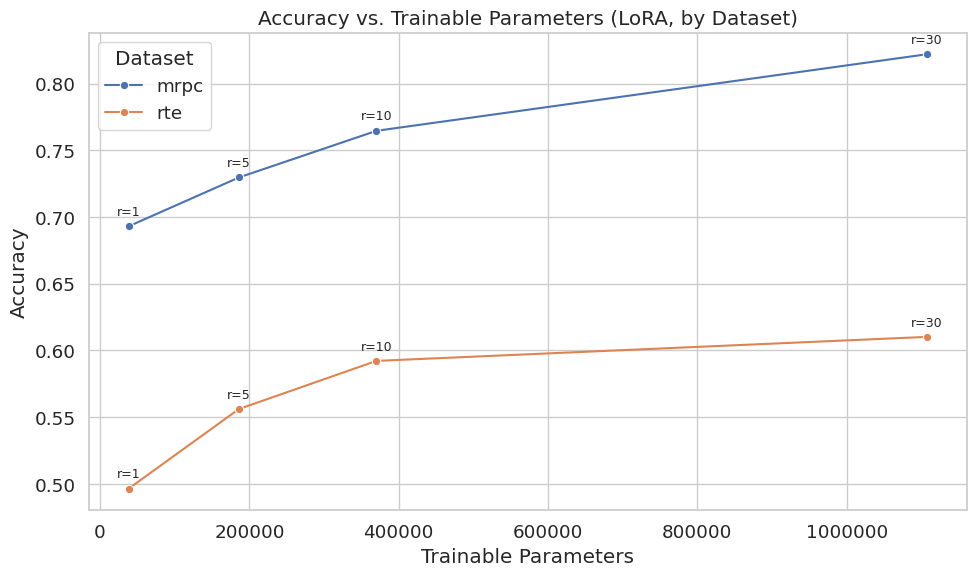

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Load CSV
df = pd.read_csv("lora_results.csv")

# Group by dataset + lora_rank and average accuracy/params
grouped = df.groupby(["dataset", "lora_rank"]).agg({
    "accuracy": "mean",
    "trainable_params": "mean"
}).reset_index()

# Set style
sns.set(style="whitegrid", font_scale=1.2)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=grouped,
    x="trainable_params",
    y="accuracy",
    hue="dataset",
    marker="o"
)

# Format x-axis to show full numbers
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style="plain", axis="x")

# Annotate each point with r
for _, row in grouped.iterrows():
    plt.annotate(
        f"r={int(row['lora_rank'])}",
        (row["trainable_params"], row["accuracy"]),
        textcoords="offset points", xytext=(0, 8), ha='center', fontsize=9
    )

plt.xlabel("Trainable Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Trainable Parameters (LoRA, by Dataset)")
plt.tight_layout()
plt.legend(title="Dataset")
plt.show()


In [12]:
results3 = []
for r in [1, 5, 10, 30]:
    res = run_lora_experiment("sst2", lora_rank=r)
    results3.append(res)

# You can now print them or save as DataFrame
print(pd.DataFrame(results3))

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔢 Trainable parameters (LoRA r=1): 38,402
🧪 Using validation set for SST2 (test set not safe)


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


✅ Unique eval labels: {0, 1}


Epoch,Training Loss,Validation Loss,Accuracy
1,0.297800,0.267672,0.895642
2,0.244500,0.255262,0.903670
3,0.263900,0.256447,0.905963


✅ SST2 | LoRA r=1 | Accuracy: 0.9037
💾 Saved best model to: ./lora_r1_sst2_output/best_model.pt


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔢 Trainable parameters (LoRA r=5): 185,858
🧪 Using validation set for SST2 (test set not safe)
✅ Unique eval labels: {0, 1}


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.264000,0.244442,0.904817
2,0.206800,0.247981,0.905963
3,0.238700,0.251960,0.908257


✅ SST2 | LoRA r=5 | Accuracy: 0.9048
💾 Saved best model to: ./lora_r5_sst2_output/best_model.pt


Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔢 Trainable parameters (LoRA r=10): 370,178
🧪 Using validation set for SST2 (test set not safe)
✅ Unique eval labels: {0, 1}


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.258600,0.245105,0.905963
2,0.182000,0.250986,0.905963
3,0.227100,0.254689,0.908257


✅ SST2 | LoRA r=10 | Accuracy: 0.9060
💾 Saved best model to: ./lora_r10_sst2_output/best_model.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔢 Trainable parameters (LoRA r=30): 1,107,458
🧪 Using validation set for SST2 (test set not safe)
✅ Unique eval labels: {0, 1}


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.242400,0.247829,0.903670
2,0.155200,0.256097,0.913991
3,0.198800,0.266498,0.916284


✅ SST2 | LoRA r=30 | Accuracy: 0.9037
💾 Saved best model to: ./lora_r30_sst2_output/best_model.pt
  dataset  lora_rank  trainable_params  accuracy  \
0    sst2          1             38402    0.9037   
1    sst2          5            185858    0.9048   
2    sst2         10            370178    0.9060   
3    sst2         30           1107458    0.9037   

                             model_path  
0   ./lora_r1_sst2_output/best_model.pt  
1   ./lora_r5_sst2_output/best_model.pt  
2  ./lora_r10_sst2_output/best_model.pt  
3  ./lora_r30_sst2_output/best_model.pt  


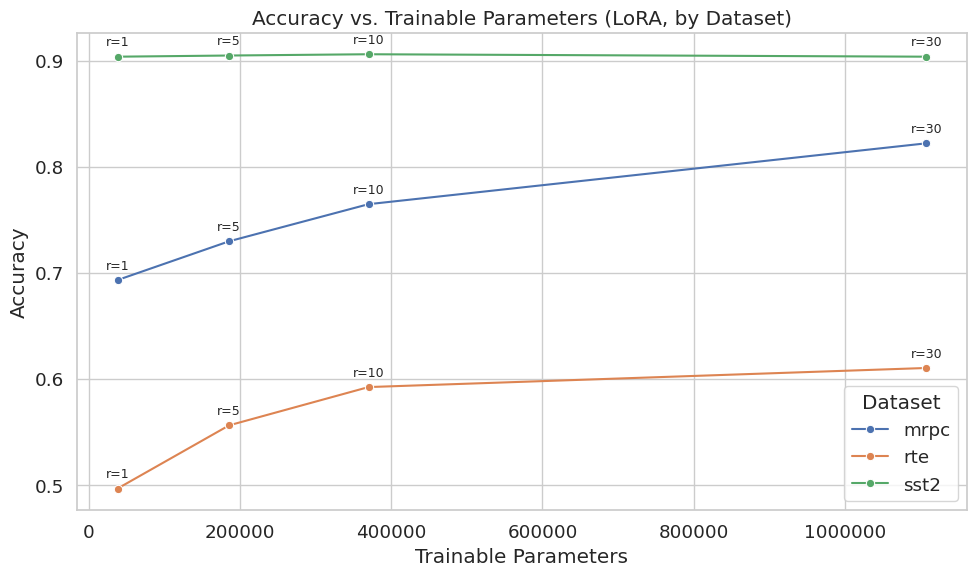

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Load CSV
df = pd.read_csv("lora_results.csv")

# Group by dataset + lora_rank and average accuracy/params
grouped = df.groupby(["dataset", "lora_rank"]).agg({
    "accuracy": "mean",
    "trainable_params": "mean"
}).reset_index()

# Set style
sns.set(style="whitegrid", font_scale=1.2)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=grouped,
    x="trainable_params",
    y="accuracy",
    hue="dataset",
    marker="o"
)

# Format x-axis to show full numbers
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style="plain", axis="x")

# Annotate each point with r
for _, row in grouped.iterrows():
    plt.annotate(
        f"r={int(row['lora_rank'])}",
        (row["trainable_params"], row["accuracy"]),
        textcoords="offset points", xytext=(0, 8), ha='center', fontsize=9
    )

plt.xlabel("Trainable Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Trainable Parameters (LoRA, by Dataset)")
plt.tight_layout()
plt.legend(title="Dataset")
plt.show()


In [10]:
results = []
for r in [1, 5, 10, 30]:
    res = run_lora_experiment("imdb", lora_rank=r)
    results.append(res)

# You can now print them or save as DataFrame
print(pd.DataFrame(results))

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔢 Trainable parameters (LoRA r=1): 38,402
🧪 Using validation set for IMDB
✅ Unique eval labels: {0, 1}


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.266500,0.303653,0.882400
2,0.252500,0.244696,0.905200
3,0.238100,0.234587,0.909600


✅ IMDB | LoRA r=1 | Accuracy: 0.9096
💾 Saved best model to: ./lora_r1_imdb_output/best_model.pt


Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔢 Trainable parameters (LoRA r=5): 185,858
🧪 Using validation set for IMDB


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


✅ Unique eval labels: {0, 1}


Epoch,Training Loss,Validation Loss,Accuracy
1,0.243900,0.261825,0.897200
2,0.224400,0.247084,0.908400
3,0.207500,0.219829,0.913200


✅ IMDB | LoRA r=5 | Accuracy: 0.9132
💾 Saved best model to: ./lora_r5_imdb_output/best_model.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔢 Trainable parameters (LoRA r=10): 370,178
🧪 Using validation set for IMDB


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


✅ Unique eval labels: {0, 1}


Epoch,Training Loss,Validation Loss,Accuracy
1,0.236500,0.286412,0.891200
2,0.213000,0.250995,0.906400
3,0.197500,0.218884,0.920800


✅ IMDB | LoRA r=10 | Accuracy: 0.9208
💾 Saved best model to: ./lora_r10_imdb_output/best_model.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔢 Trainable parameters (LoRA r=30): 1,107,458
🧪 Using validation set for IMDB


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


✅ Unique eval labels: {0, 1}


Epoch,Training Loss,Validation Loss,Accuracy
1,0.232400,0.243363,0.907600
2,0.194100,0.246352,0.914000
3,0.176400,0.217012,0.928000


✅ IMDB | LoRA r=30 | Accuracy: 0.9280
💾 Saved best model to: ./lora_r30_imdb_output/best_model.pt
  dataset  lora_rank  trainable_params  accuracy  \
0    imdb          1             38402    0.9096   
1    imdb          5            185858    0.9132   
2    imdb         10            370178    0.9208   
3    imdb         30           1107458    0.9280   

                             model_path  
0   ./lora_r1_imdb_output/best_model.pt  
1   ./lora_r5_imdb_output/best_model.pt  
2  ./lora_r10_imdb_output/best_model.pt  
3  ./lora_r30_imdb_output/best_model.pt  


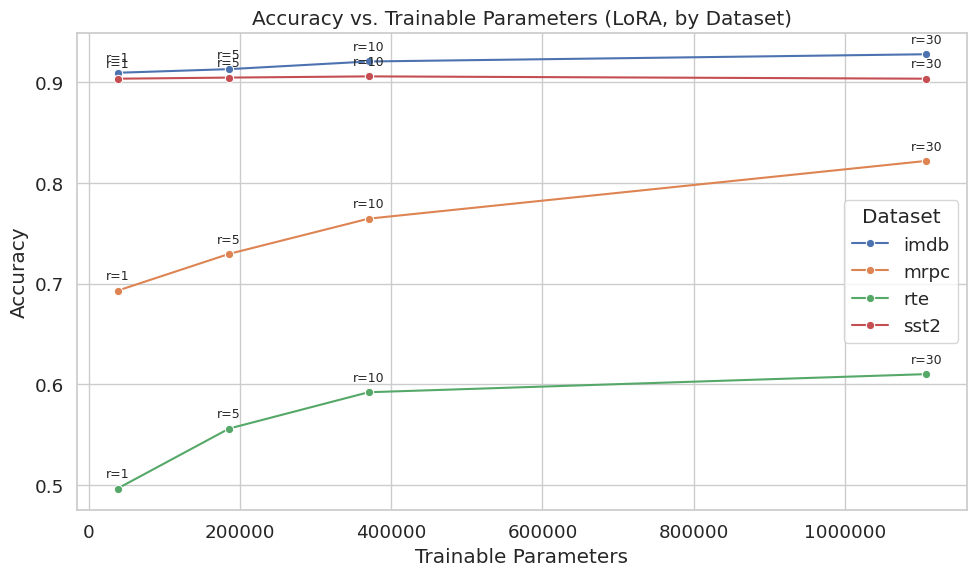

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Load CSV
df = pd.read_csv("lora_results.csv")

# Group by dataset + lora_rank and average accuracy/params
grouped = df.groupby(["dataset", "lora_rank"]).agg({
    "accuracy": "mean",
    "trainable_params": "mean"
}).reset_index()

# Set style
sns.set(style="whitegrid", font_scale=1.2)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=grouped,
    x="trainable_params",
    y="accuracy",
    hue="dataset",
    marker="o"
)

# Format x-axis to show full numbers
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style="plain", axis="x")

# Annotate each point with r
for _, row in grouped.iterrows():
    plt.annotate(
        f"r={int(row['lora_rank'])}",
        (row["trainable_params"], row["accuracy"]),
        textcoords="offset points", xytext=(0, 8), ha='center', fontsize=9
    )

plt.xlabel("Trainable Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Trainable Parameters (LoRA, by Dataset)")
plt.tight_layout()
plt.legend(title="Dataset")
plt.show()


In [11]:
results = []

for r in [1, 5, 10, 30]:
    res = run_lora_experiment("tweet", lora_rank=r)
    results.append(res)

# You can now print them or save as DataFrame
print(pd.DataFrame(results))

✅ Encoded TweetEval train label values: tensor([0, 1, 2])
✅ Encoded TweetEval validation label values: tensor([0, 1, 2])


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔢 Trainable parameters (LoRA r=1): 39,171
✅ Unique eval labels: {0, 1, 2}
Model expects num_labels = 3
Label distribution: Counter({1: 20673, 2: 17849, 0: 7093})


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.702600,0.685575,0.687500
2,0.678900,0.670663,0.702000
3,0.670500,0.665732,0.706000


✅ TWEET | LoRA r=1 | Accuracy: 0.7060
💾 Saved best model to: ./lora_r1_tweet_output/best_model.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Encoded TweetEval train label values: tensor([0, 1, 2])
✅ Encoded TweetEval validation label values: tensor([0, 1, 2])
🔢 Trainable parameters (LoRA r=5): 186,627


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


✅ Unique eval labels: {0, 1, 2}
Model expects num_labels = 3
Label distribution: Counter({1: 20673, 2: 17849, 0: 7093})


Epoch,Training Loss,Validation Loss,Accuracy
1,0.680000,0.661205,0.695500
2,0.661500,0.650960,0.710000
3,0.629400,0.641014,0.714500


✅ TWEET | LoRA r=5 | Accuracy: 0.7145
💾 Saved best model to: ./lora_r5_tweet_output/best_model.pt
✅ Encoded TweetEval train label values: tensor([0, 1, 2])
✅ Encoded TweetEval validation label values: tensor([0, 1, 2])


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔢 Trainable parameters (LoRA r=10): 370,947
✅ Unique eval labels: {0, 1, 2}
Model expects num_labels = 3
Label distribution: Counter({1: 20673, 2: 17849, 0: 7093})


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.669900,0.651163,0.709000
2,0.643900,0.641666,0.721000
3,0.614700,0.630106,0.725500


✅ TWEET | LoRA r=10 | Accuracy: 0.7255
💾 Saved best model to: ./lora_r10_tweet_output/best_model.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Encoded TweetEval train label values: tensor([0, 1, 2])
✅ Encoded TweetEval validation label values: tensor([0, 1, 2])
🔢 Trainable parameters (LoRA r=30): 1,108,227
✅ Unique eval labels: {0, 1, 2}
Model expects num_labels = 3
Label distribution: Counter({1: 20673, 2: 17849, 0: 7093})


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.660800,0.641592,0.717000
2,0.628600,0.631510,0.729500
3,0.593600,0.627144,0.730000


✅ TWEET | LoRA r=30 | Accuracy: 0.7300
💾 Saved best model to: ./lora_r30_tweet_output/best_model.pt
  dataset  lora_rank  trainable_params  accuracy  \
0   tweet          1             39171    0.7060   
1   tweet          5            186627    0.7145   
2   tweet         10            370947    0.7255   
3   tweet         30           1108227    0.7300   

                              model_path  
0   ./lora_r1_tweet_output/best_model.pt  
1   ./lora_r5_tweet_output/best_model.pt  
2  ./lora_r10_tweet_output/best_model.pt  
3  ./lora_r30_tweet_output/best_model.pt  


In [32]:
results = []

for r in [1, 5, 10, 30]:
    res = run_lora_experiment("tweet_emotion", lora_rank=r)
    results.append(res)

# You can now print them or save as DataFrame
print(pd.DataFrame(results))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Encoded TweetEval train label values: tensor([0, 1, 2, 3])
✅ Encoded TweetEval validation label values: tensor([0, 1, 2, 3])
🔢 Trainable parameters (LoRA r=1): 39,940
✅ Unique eval labels: {0, 1, 2, 3}
Model expects num_labels = 4
Label distribution: Counter({0: 1400, 3: 855, 1: 708, 2: 294})


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.282500,1.247450,0.430481
2,1.231000,1.229636,0.430481
3,1.232900,1.217414,0.430481


✅ TWEET_EMOTION | LoRA r=1 | Accuracy: 0.4305
💾 Saved best model to: ./lora_r1_tweet_emotion_output/best_model.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Encoded TweetEval train label values: tensor([0, 1, 2, 3])
✅ Encoded TweetEval validation label values: tensor([0, 1, 2, 3])
🔢 Trainable parameters (LoRA r=5): 187,396


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


✅ Unique eval labels: {0, 1, 2, 3}
Model expects num_labels = 4
Label distribution: Counter({0: 1400, 3: 855, 1: 708, 2: 294})


Epoch,Training Loss,Validation Loss,Accuracy
1,1.272900,1.231191,0.427807
2,1.065800,0.954468,0.617647
3,0.923800,0.870082,0.665775


✅ TWEET_EMOTION | LoRA r=5 | Accuracy: 0.6658
💾 Saved best model to: ./lora_r5_tweet_emotion_output/best_model.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Encoded TweetEval train label values: tensor([0, 1, 2, 3])
✅ Encoded TweetEval validation label values: tensor([0, 1, 2, 3])
🔢 Trainable parameters (LoRA r=10): 371,716


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


✅ Unique eval labels: {0, 1, 2, 3}
Model expects num_labels = 4
Label distribution: Counter({0: 1400, 3: 855, 1: 708, 2: 294})


Epoch,Training Loss,Validation Loss,Accuracy
1,1.253600,1.187591,0.459893
2,0.946800,0.837814,0.679144
3,0.838500,0.799241,0.700535


✅ TWEET_EMOTION | LoRA r=10 | Accuracy: 0.7005
💾 Saved best model to: ./lora_r10_tweet_emotion_output/best_model.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Encoded TweetEval train label values: tensor([0, 1, 2, 3])
✅ Encoded TweetEval validation label values: tensor([0, 1, 2, 3])
🔢 Trainable parameters (LoRA r=30): 1,108,996


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


✅ Unique eval labels: {0, 1, 2, 3}
Model expects num_labels = 4
Label distribution: Counter({0: 1400, 3: 855, 1: 708, 2: 294})


Epoch,Training Loss,Validation Loss,Accuracy
1,1.110700,0.951470,0.633690
2,0.845900,0.759400,0.732620
3,0.698000,0.709448,0.748663


✅ TWEET_EMOTION | LoRA r=30 | Accuracy: 0.7487
💾 Saved best model to: ./lora_r30_tweet_emotion_output/best_model.pt
         dataset  lora_rank  trainable_params  accuracy  \
0  tweet_emotion          1             39940    0.4305   
1  tweet_emotion          5            187396    0.6658   
2  tweet_emotion         10            371716    0.7005   
3  tweet_emotion         30           1108996    0.7487   

                                      model_path  
0   ./lora_r1_tweet_emotion_output/best_model.pt  
1   ./lora_r5_tweet_emotion_output/best_model.pt  
2  ./lora_r10_tweet_emotion_output/best_model.pt  
3  ./lora_r30_tweet_emotion_output/best_model.pt  


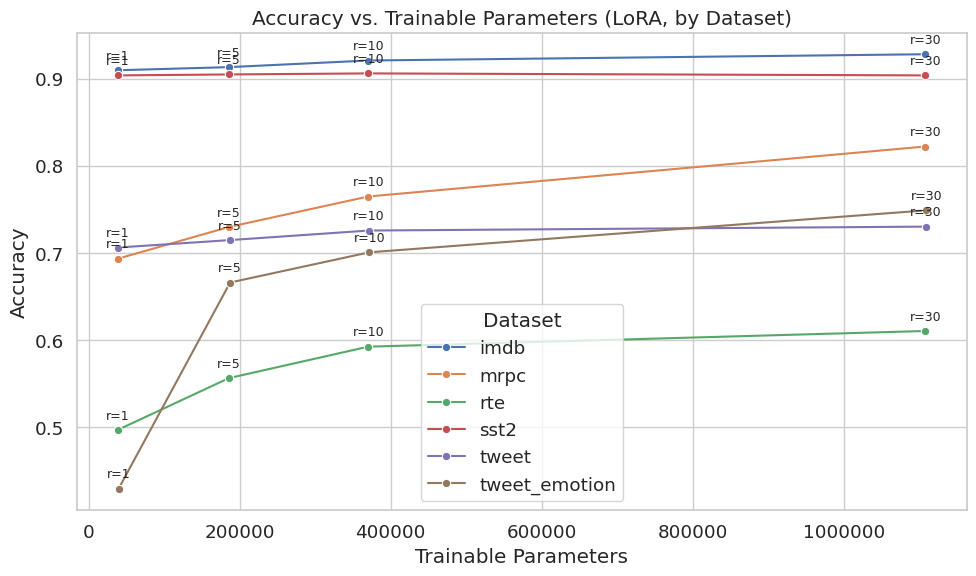

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Load CSV
df = pd.read_csv("lora_results.csv")

# Group by dataset + lora_rank and average accuracy/params
grouped = df.groupby(["dataset", "lora_rank"]).agg({
    "accuracy": "mean",
    "trainable_params": "mean"
}).reset_index()

# Set style
sns.set(style="whitegrid", font_scale=1.2)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=grouped,
    x="trainable_params",
    y="accuracy",
    hue="dataset",
    marker="o"
)

# Format x-axis to show full numbers
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style="plain", axis="x")

# Annotate each point with r
for _, row in grouped.iterrows():
    plt.annotate(
        f"r={int(row['lora_rank'])}",
        (row["trainable_params"], row["accuracy"]),
        textcoords="offset points", xytext=(0, 8), ha='center', fontsize=9
    )

plt.xlabel("Trainable Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Trainable Parameters (LoRA, by Dataset)")
plt.tight_layout()
plt.legend(title="Dataset")
plt.show()


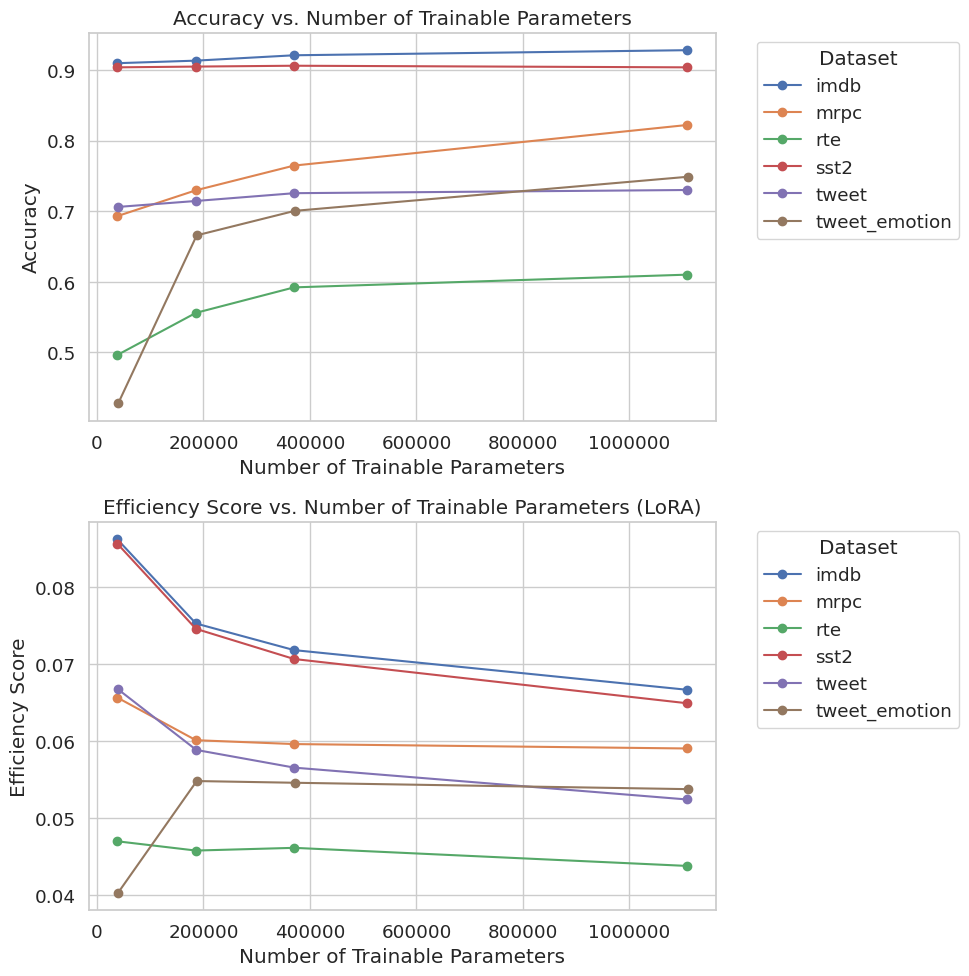

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

# === Load CSV ===
df = pd.read_csv("lora_results.csv")

# === Group by dataset + lora_rank to average points ===
grouped = df.groupby(['dataset', 'lora_rank']).agg({
    'accuracy': 'mean',
    'trainable_params': 'mean'
}).reset_index()

# === Compute efficiency ===
grouped['efficiency'] = grouped['accuracy'] / np.log(grouped['trainable_params'] + 1)

# === Style ===
sns.set(style="whitegrid", font_scale=1.2)

# === Plot ===
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# === Accuracy Plot ===
for ds in grouped['dataset'].unique():
    subset = grouped[grouped['dataset'] == ds]
    axes[0].plot(subset['trainable_params'], subset['accuracy'], marker='o', label=ds)
    # for _, row in subset.iterrows():
    #     axes[0].annotate(f"r={int(row['lora_rank'])}", 
    #                      (row['trainable_params'], row['accuracy']), 
    #                      textcoords="offset points", xytext=(0, 8), ha='center', fontsize=9)

axes[0].set_title('Accuracy vs. Number of Trainable Parameters')
axes[0].set_xlabel('Number of Trainable Parameters')
axes[0].set_ylabel('Accuracy')
axes[0].xaxis.set_major_formatter(ScalarFormatter())
axes[0].ticklabel_format(style='plain', axis='x')
axes[0].legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')

# === Efficiency Plot ===
for ds in grouped['dataset'].unique():
    subset = grouped[grouped['dataset'] == ds]
    axes[1].plot(subset['trainable_params'], subset['efficiency'], marker='o', label=ds)
    # for _, row in subset.iterrows():
    #     axes[1].annotate(f"r={int(row['lora_rank'])}", 
    #                      (row['trainable_params'], row['efficiency']), 
    #                      textcoords="offset points", xytext=(0, 8), ha='center', fontsize=9)

axes[1].set_title('Efficiency Score vs. Number of Trainable Parameters (LoRA)')
axes[1].set_xlabel('Number of Trainable Parameters')
axes[1].set_ylabel('Efficiency Score')
axes[1].xaxis.set_major_formatter(ScalarFormatter())
axes[1].ticklabel_format(style='plain', axis='x')
axes[1].legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


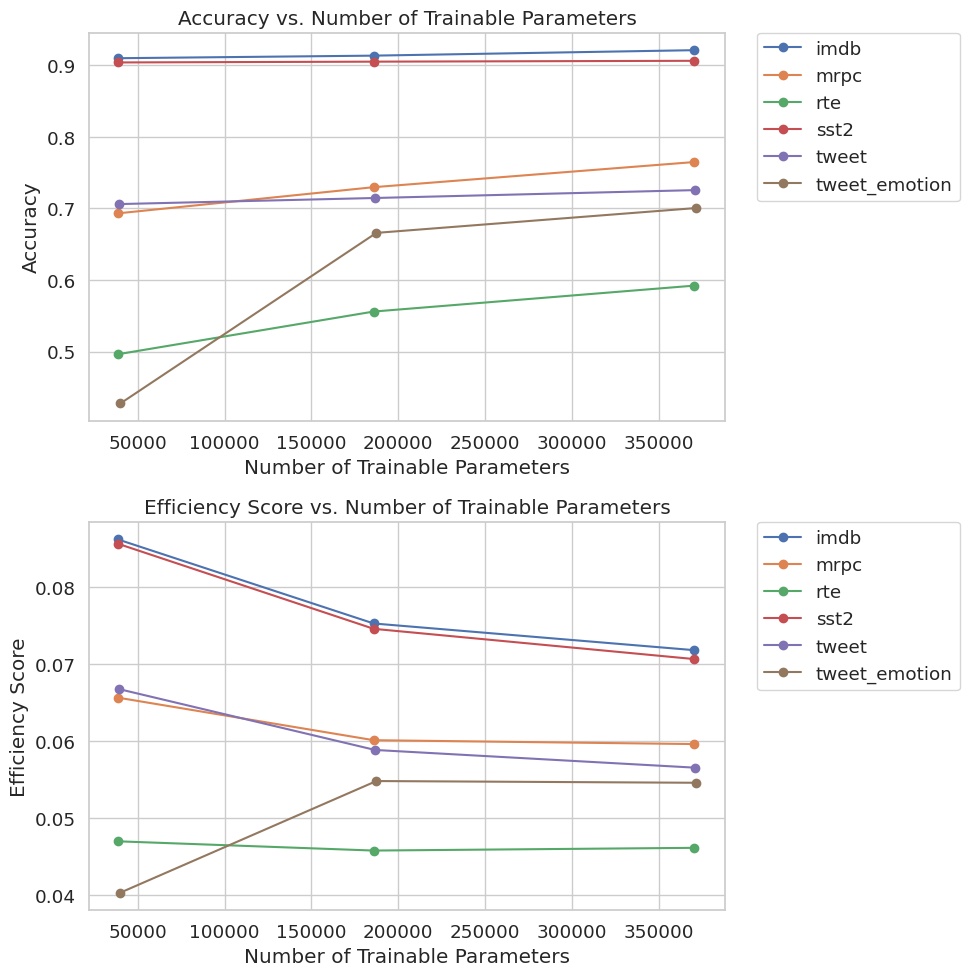

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# === Load and aggregate CSV ===
df = pd.read_csv("lora_results.csv")

# Average over multiple runs per (dataset, lora_rank)
df = df.groupby(['dataset', 'lora_rank']).agg({
    'accuracy': 'mean',
    'trainable_params': 'mean'
}).reset_index()

# Filter out r = 30
df = df[df['lora_rank'] != 30]

# Compute efficiency
df['efficiency'] = df['accuracy'] / np.log(df['trainable_params'] + 1)

# === Plot using your layout ===
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

for ds in df['dataset'].unique():
    subset = df[df['dataset'] == ds]
    axes[0].plot(subset['trainable_params'], subset['accuracy'], marker='o', label=ds)
    axes[1].plot(subset['trainable_params'], subset['efficiency'], marker='o', label=ds)

axes[0].set_title('Accuracy vs. Number of Trainable Parameters')
axes[0].set_xlabel('Number of Trainable Parameters')
axes[0].set_ylabel('Accuracy')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

axes[1].set_title('Efficiency Score vs. Number of Trainable Parameters')
axes[1].set_xlabel('Number of Trainable Parameters')
axes[1].set_ylabel('Efficiency Score')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()
